## The Taxi Problem  

from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
by Tom Dietterich


**Description**   
There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. Once the passenger is dropped off, the episode ends.

**Observations**   
There are 500 discrete actions since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations. 


**Actions**   
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

**Rewards**   
    There is a reward of -1 for each action and an additional reward of +20 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

**Rendering**
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters: locations


### Setup

In [1]:
import gym 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# For animation 
from IPython.display import clear_output
from time import sleep

In [91]:
class Agent: 
    def __init__(self, method, start_alpha = 0.1, start_gamma = 0.9, start_epsilon = 0.1):
        """method: one of 'q_learning', 'sarsa' or 'expected_sarsa' """
        self.method = method
        self.env = gym.make('Taxi-v2')
        self.n_squares = 25 
        self.n_passenger_locs = 5 
        self.n_dropoffs = 4 
        self.n_actions = self.env.action_space.n
        self.epsilon = start_epsilon
        self.gamma = start_gamma
        self.alpha = start_alpha
        # Set up initial q-table 
        self.q = np.zeros(shape = (self.n_squares*self.n_passenger_locs*self.n_dropoffs, self.env.action_space.n))
        # Set up policy pi, init as equiprobable random policy
        self.pi = np.zeros_like(self.q)
        for i in range(self.pi.shape[0]): 
            for a in range(self.n_actions): 
                self.pi[i,a] = 1/self.n_actions
        
    def simulate_episode(self):
        s = self.env.reset()
        done = False
        r_sum = 0 
        n_steps = 0 
        gam = self.gamma
        while not done: 
            n_steps += 1
            # take action from policy
            x = np.random.random()
            a = np.argmax(np.cumsum(self.pi[s,:]) > x) 
            # take step 
            s_prime,r,done,info = self.env.step(a)    
            if self.method == 'q_learning': 
                a_prime = np.random.choice(np.where(self.q[s_prime] == max(self.q[s_prime]))[0])
                self.q[s,a] = self.q[s,a] + self.alpha * \
                    (r + gam*self.q[s_prime,a_prime] - self.q[s,a])
            elif self.method == 'sarsa': 
                a_prime = np.argmax(np.cumsum(self.pi[s_prime,:]) > np.random.random())
                self.q[s,a] = self.q[s,a] + self.alpha * \
                    (r + gam*self.q[s_prime,a_prime ] - self.q[s,a])
            elif self.method == 'expected_sarsa':
                self.q[s,a] = self.q[s,a] + self.alpha * \
                    (r + gam* np.dot(self.pi[s_prime,:],self.q[s_prime,:]) - self.q[s,a])
            else: 
                raise Exception("Invalid method provided")
            # update policy
            best_a = np.random.choice(np.where(self.q[s] == max(self.q[s]))[0])
            for i in range(self.n_actions): 
                if i == best_a:      self.pi[s,i] = 1 - (self.n_actions-1)*(self.epsilon / self.n_actions)
                else:                self.pi[s,i] = self.epsilon / self.n_actions
       
            # decay gamma close to the end of the episode
            if n_steps > 185: 
                gam *= 0.875
            s = s_prime
            r_sum += r
        return r_sum


In [ ]:
def simulate_episode(self):
    s = self.env.reset()
    done = False
    r_sum = 0 
    n_steps = 0 
    gam = self.gamma
    while not done: 
        n_steps += 1
        # take action from policy
        x = np.random.random()
        a = np.argmax(np.cumsum(self.pi[s,:]) > x) 
        # take step 
        s_prime,r,done,info = self.env.step(a)    
        if self.method == 'q_learning': 
            a_prime = np.random.choice(np.where(self.q[s_prime] == max(self.q[s_prime]))[0])
            self.q[s,a] = self.q[s,a] + self.alpha * \
                (r + gam*self.q[s_prime,a_prime] - self.q[s,a])
        elif self.method == 'sarsa': 
            a_prime = np.argmax(np.cumsum(self.pi[s_prime,:]) > np.random.random())
            self.q[s,a] = self.q[s,a] + self.alpha * \
                (r + gam*self.q[s_prime,a_prime ] - self.q[s,a])
        elif self.method == 'expected_sarsa':
            self.q[s,a] = self.q[s,a] + self.alpha * \
                (r + gam* np.dot(self.pi[s_prime,:],self.q[s_prime,:]) - self.q[s,a])
        else: 
            raise Exception("Invalid method provided")
        # update policy
        best_a = np.random.choice(np.where(self.q[s] == max(self.q[s]))[0])
        for i in range(self.n_actions): 
            if i == best_a:      self.pi[s,i] = 1 - (self.n_actions-1)*(self.epsilon / self.n_actions)
            else:                self.pi[s,i] = self.epsilon / self.n_actions

        # decay gamma close to the end of the episode
        if n_steps > 185: 
            gam *= 0.875
        s = s_prime
        r_sum += r
    return r_sum

In [107]:
def train_agent(agent, n_episodes= 200001, epsilon_decay = 0.99995, alpha_decay = 0.99995, print_trace = False):
    r_sums = []
    for ep in range(n_episodes): 
        r_sum = agent.simulate_episode()
        # decrease epsilon and learning rate 
        agent.epsilon *= epsilon_decay
        agent.alpha *= alpha_decay
        if print_trace: 
            if ep % 20000 == 0 and ep > 0 : 
                print("Episode:", ep, "alpha:", np.round(agent.alpha, 3), "epsilon:",  np.round(agent.epsilon, 3))
                print ("Last 100 episodes avg reward: ", np.mean(r_sums[ep-100:ep]))
        r_sums.append(r_sum)
    return r_sums

In [108]:
# Create agents 
sarsa_agent = Agent(method='sarsa')
e_sarsa_agent = Agent(method='expected_sarsa')
q_learning_agent = Agent(method='q_learning')

# Train agents
r_sums_sarsa = train_agent(sarsa_agent, print_trace=True)
r_sums_e_sarsa = train_agent(e_sarsa_agent, print_trace=True)
r_sums_q_learning = train_agent(q_learning_agent, print_trace=True)

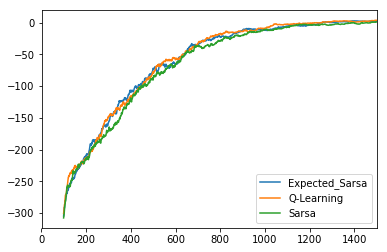

In [116]:
df =pd.DataFrame({"Sarsa": r_sums_sarsa, 
             "Expected_Sarsa": r_sums_e_sarsa, 
             "Q-Learning": r_sums_q_learning})
df_ma = df.rolling(100, min_periods = 100).mean()
df_ma.iloc[1:1500].plot()

In [114]:
np.max(df_ma)

Expected_Sarsa    9.50
Q-Learning        9.44
Sarsa             9.42
dtype: float64

### Looking at the policy for a state 

In [40]:
agent = sarsa_agent
policy = np.zeros((5,5))
for i in range(5): 
    for j in range(5):
        policy[i,j] = np.argmax(agent.q[agent.env.env.encode(i,j,4,0),:])

In [41]:
policy

array([[ 5.,  3.,  0.,  3.,  3.],
       [ 1.,  1.,  3.,  3.,  3.],
       [ 1.,  1.,  1.,  3.,  3.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  3.,  1.,  3.]])

In [42]:
policy

array([[ 5.,  3.,  0.,  3.,  3.],
       [ 1.,  1.,  3.,  3.,  3.],
       [ 1.,  1.,  1.,  3.,  3.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  3.,  1.,  3.]])

In [43]:
policy

array([[ 5.,  3.,  0.,  3.,  3.],
       [ 1.,  1.,  3.,  3.,  3.],
       [ 1.,  1.,  1.,  3.,  3.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  3.,  1.,  3.]])

# Viewing the final policy 

In [44]:
def generate_frames(agent, start_state):
    agent.env.reset()
    agent.env.env.s = start_state
    s = start_state
    policy = np.argmax(agent.pi,axis =1)
    epochs = 0
    penalties, reward = 0, 0
    frames = [] 
    done = False
    frames.append({
        'frame': agent.env.render(mode='ansi'),
        'state': agent.env.env.s ,
        'action': "Start",
        'reward': 0
        }
    )
    while not done:
        a = policy[s]
        s, reward, done, info = agent.env.step(a)
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': agent.env.render(mode='ansi'),
            'state': s,
            'action': a,
            'reward': reward
            }
        )
        epochs += 1
    print("Timesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    return frames

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.4)
        

In [47]:
agent = sarsa_agent
start_state= 314
frames = generate_frames(agent, start_state)
print_frames(frames)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 16
State: 418
Action: 5
Reward: 20
